In [12]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import calendar
import folium
import matplotlib.cm as cm
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import os
import pandas as pd
import re

plt.rcParams.update({"font.size": 20})



In [13]:
def read_water_gage_station(filename):
    df = pd.read_csv(
        filename,
        index_col="time",
    )
    return df


# MeteostatStationLNFT5 = pd.read_excel("Meteostat_LNFT5.xlsx", index_col="time")
# MeteostatStationKBYY0 = pd.read_excel("Meteostat_KBYY0.xlsx", index_col="time")
# MeteostatStationKLBX0 = pd.read_excel("Meteostat_KLBX0.xlsx", index_col="time")
MeteostatStationLNFT5 = read_water_gage_station("Meteostat_LNFT5.csv")
MeteostatStationKBYY0 = read_water_gage_station("Meteostat_KBYY0.csv")
MeteostatStationKLBX0 = read_water_gage_station("Meteostat_KLBX0.csv")


In [14]:
# MeteostatStationKLBX0.to_csv("Meteostat_KLBX0.csv")
# MeteostatStationKBYY0.to_csv("Meteostat_KBYY0.csv")
# MeteostatStationLNFT5.to_csv("Meteostat_LNFT5.csv")


In [15]:
month_map = {
    1: "January",
    2: "February",
    3: "March",
    4: "April",
    5: "May",
    6: "June",
    7: "July",
    8: "August",
    9: "September",
    10: "October",
    11: "November",
    12: "December",
}

month_order = [
    "January",
    "February",
    "March",
    "April",
    "May",
    "June",
    "July",
    "August",
    "September",
    "October",
    "November",
    "December",
]

rename_columns = {
    "air_temperature": "Air Temperature (°C)",
    "dewpoint": "Dew Point (°C)",
    "relative_humidity": "Relative Humidity (%)",
    "total_precipitation": "Total Precipitation (mm)",
    "snow_depth": "Snow Depth (m)",
    "wind_direction": "Wind (From) Direction (Degrees)",
    "average_wind_speed": "Average Wind Speed (km/h)",
    "wind_peak_gust": "Wind Peak Gust (km/h)",
    "sea_level_air_pressure": "Sea-Level Air Pressure (hPa)",
    "total_sunshine_duration": "Total Sunshine Duration (Minutes)",
    "weather_condition_code": "Weather Condition Code",
}


In [16]:
datasets = {
    "Station LNFT5": MeteostatStationLNFT5,
    "Station KBYY0": MeteostatStationKBYY0,
    "Station KLBX0": MeteostatStationKLBX0,
}


In [17]:
for dataset_name, df in datasets.items():
    df.rename(columns=rename_columns, inplace=True)
    for col in rename_columns.values():
        df[col] = pd.to_numeric(df[col], errors="coerce")
    df.index = pd.to_datetime(df.index)
    df.insert(0, "Year", df.index.year)
    df.insert(1, "Month", df.index.month)
    df["Month"] = df["Month"].map(month_map)
    df["Month"] = pd.Categorical(df["Month"], categories=month_order, ordered=True)
    df["Year"] = pd.Categorical(df["Year"])
    df["Average Wind Speed (km/h)"] = df["Average Wind Speed (km/h)"] * 1000 / 3600
    df.rename(
        columns={"Average Wind Speed (km/h)": "Average Wind Speed (m/s)"}, inplace=True
    )
    datasets[dataset_name] = df


In [18]:


def create_directory(base_path, subfolder):
    if base_path and subfolder:
        full_path = os.path.join(base_path, subfolder)
        os.makedirs(full_path, exist_ok=True)
    else:
        full_path = base_path
    return full_path

def adjust_dataframe(df, direction_column):
    orientation = 90 - 34
    df = df.copy()
    df[direction_column] = (df[direction_column] - orientation) % 360
    return df

def setup_plot(df, direction_column, magnitude_column):
    sns.set_theme(style="ticks")
    g = sns.JointGrid(
        data=df, x=direction_column, y=magnitude_column, marginal_ticks=True, space=0.5
    )
    return g

def customize_plot(g, df, direction_column, magnitude_column, title):
    # Kernel Density Estimate plot
    g.plot_joint(sns.kdeplot, fill=True, cut=0, thresh=0, levels=100)
    g.plot_marginals(
        sns.histplot,
        alpha=0.5,
        color="#03012d",
        stat="probability",
        fill=True,
        thresh=0,
        bins=100,
        kde=True,
        element="step",
    )
    
    # Set marginal labels to "Probability"
    g.ax_marg_x.set_xlabel("Probability")
    g.ax_marg_y.set_ylabel("Probability")
    
    # Axis labels and locators
    xlabel, ylabel = "Wind Approaching Island From ", ""
    if magnitude_column in ["Average Wind Speed (m/s)"]:
        ylabel = "Wind Speed (m/s)"
    MultipleLocator = 2
    g.set_axis_labels(xlabel, ylabel)
    g.ax_joint.yaxis.set_major_locator(ticker.MultipleLocator(MultipleLocator))
    g.ax_joint.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, _: "{:.0f}".format(y)))
    g.ax_joint.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: "{:.0f}".format(x)))
    g.ax_joint.xaxis.set_major_locator(ticker.FixedLocator([0, 90, 180, 270, 360]))
    g.ax_joint.xaxis.set_major_formatter(ticker.FixedFormatter(["E", "S", "W", "N", "E"]))
    g.ax_joint.set_xlim(0, 361)

    # Figure adjustments
    cm = 1 / 2.54
    g.fig.set_size_inches(20 * cm, 20 * cm)
    plt.suptitle(title, horizontalalignment="center", verticalalignment="top")
    plt.tight_layout()
    g.fig.set_facecolor("white")

def save_plot(g, full_path, title):
    # save_path = os.path.join(full_path, f"{title}.svg")
    save_path = f"{title}.svg"
    plt.savefig(save_path)
    # plt.close(g.fig)

# Main function to use the refactored code
def plot_kde(df, direction_column, magnitude_column, title, base_path=None, subfolder=None):
    full_path = create_directory(base_path, subfolder)
    df_adjusted = adjust_dataframe(df, direction_column)
    g = setup_plot(df_adjusted, direction_column, magnitude_column)
    customize_plot(g, df_adjusted, direction_column, magnitude_column, title)
    save_plot(g, full_path, title)


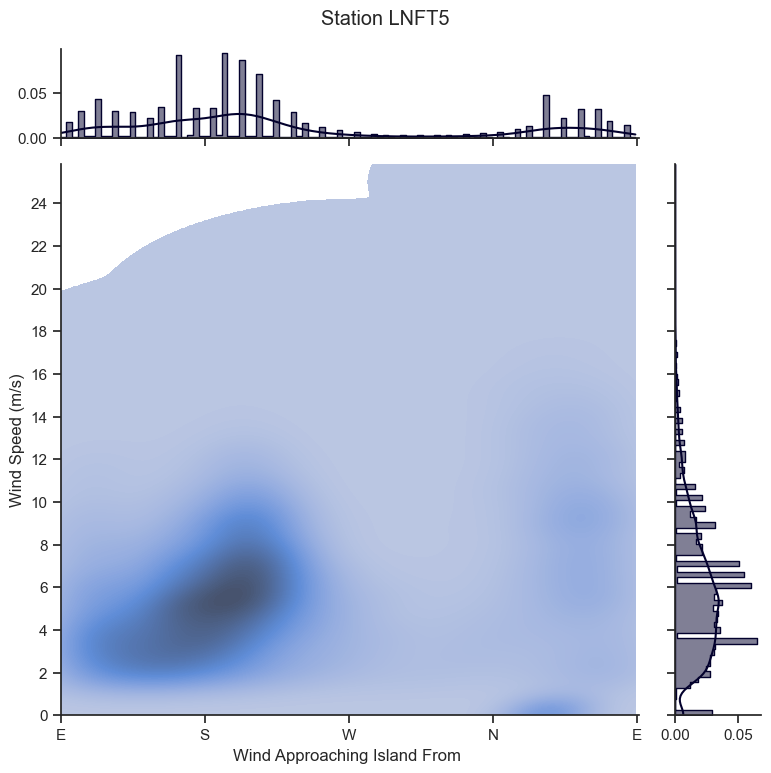

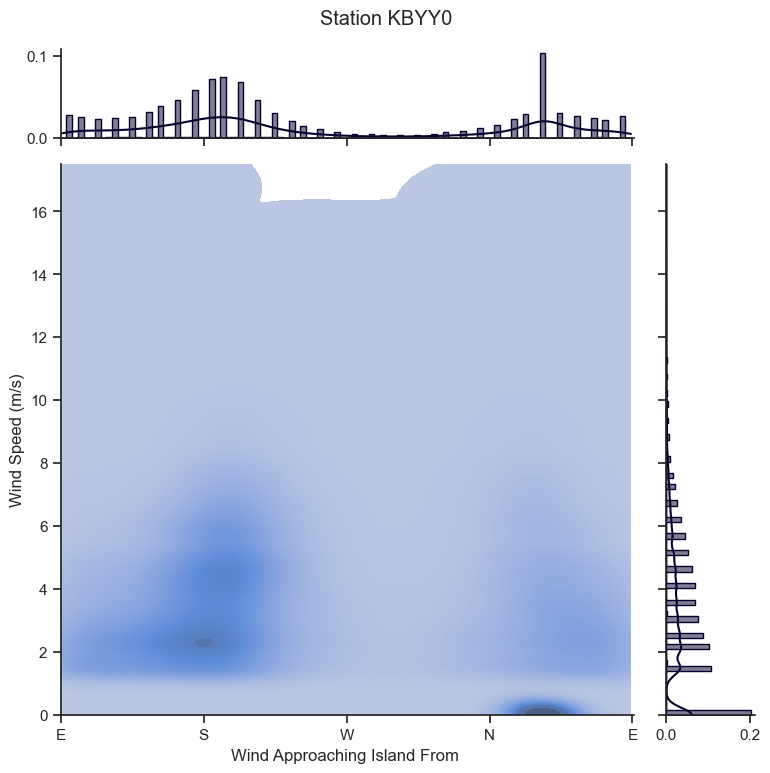

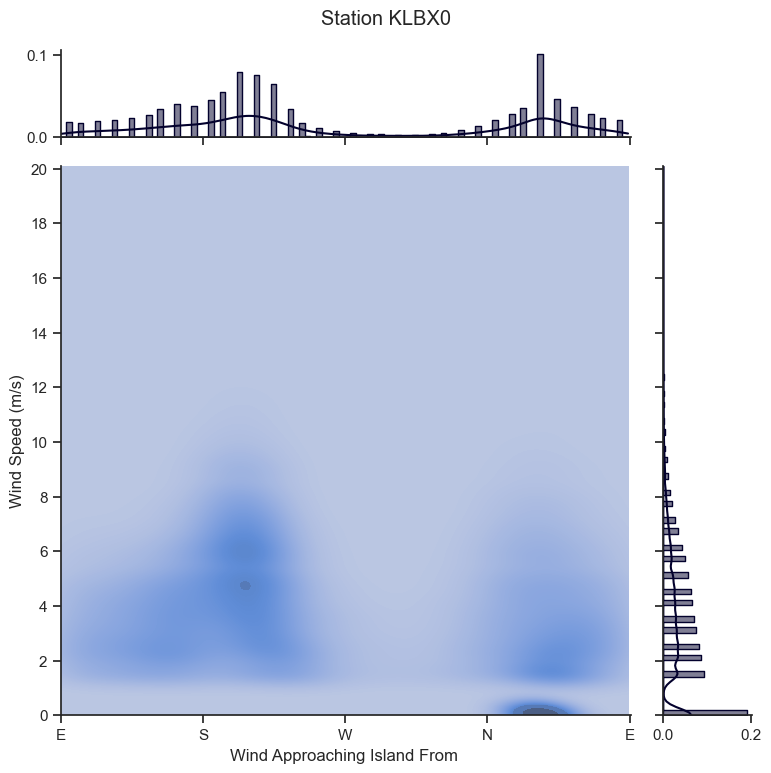

In [19]:
base_path = os.getcwd()

column_pairs = [
    ("Wind (From) Direction (Degrees)", "Average Wind Speed (m/s)"),
]
for dataset_name, df in datasets.items():
    for direction_column, magnitude_column in column_pairs:
        title = dataset_name

        plot_kde(
            df,
            direction_column=direction_column,
            magnitude_column=magnitude_column,
            title=title,
            base_path=base_path,
            subfolder=dataset_name,
        )